# MOM2  --  Smart-City  --  Telecom Nancy

**Louis-Ferdinand LAFON - Metéo LEBRUN - Bastien LOM**

Article : 

"*Peer-to-peer home energy management incorporating hydrogen storage system and solar generating units*"


Model description :

The system includes three buildings in which :

*   2 buildings are equipped with solar panels
*   1 is installed with hydrogen storage system

The buildings are connected to each other by power lines.


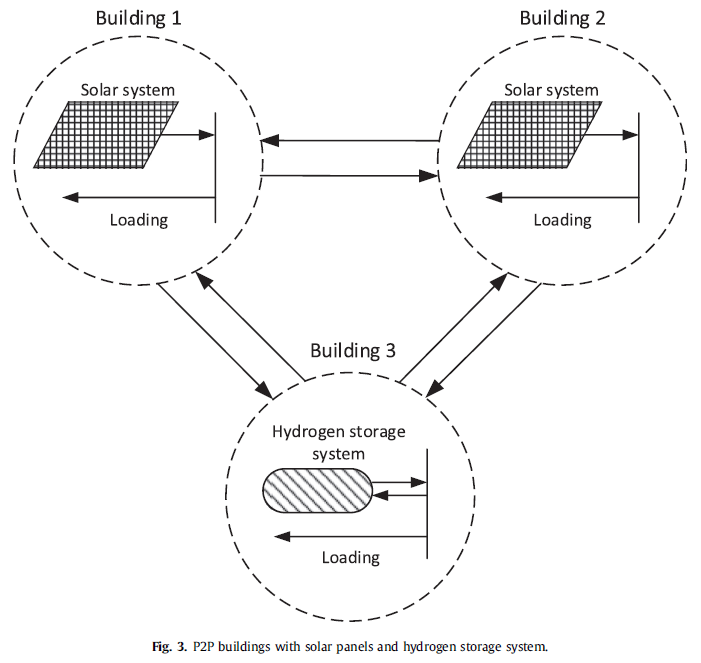


The model set up is a P2P model. A peer-to-peer network is designed around the notion of equal peer nodes simultaneously functioning as both "clients" and "servers" to the other nodes on the network. This model of network arrangement differs from the client–server model where communication is usually to and from a central server.

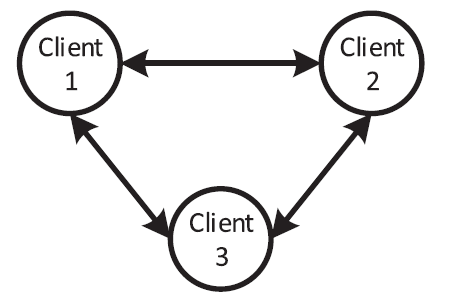


The hydrogen storage system stores excess of solar energy as hydrogen form and it afterward supplies the loads when the solar energy is not available.

The P2P operation of the buildings allows them to share their resources and energy capacities with each other. 

The P2P operation reduces the investment cost of the buildings. Because they do not need to install new energy resources and they can share their available resources with each other. The P2P system can properly balance the generation and load at all buildings and efficiently  upplies all the energy demands locally.

Data of the problem :

- Seasonal loading profile in buildings (building 1, 2 & 3)
- Seasonal solar energy profile
- Some other data :

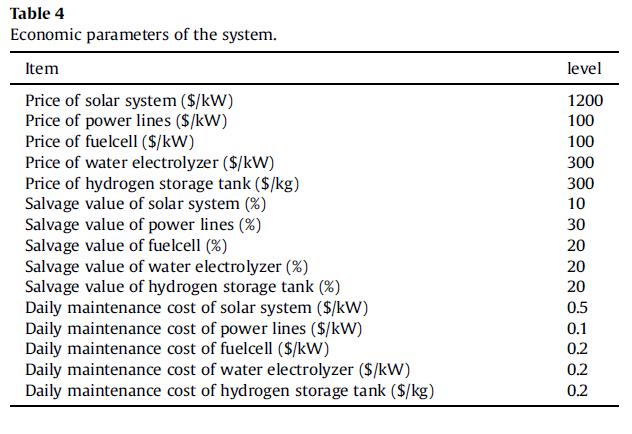






# Class diagram :


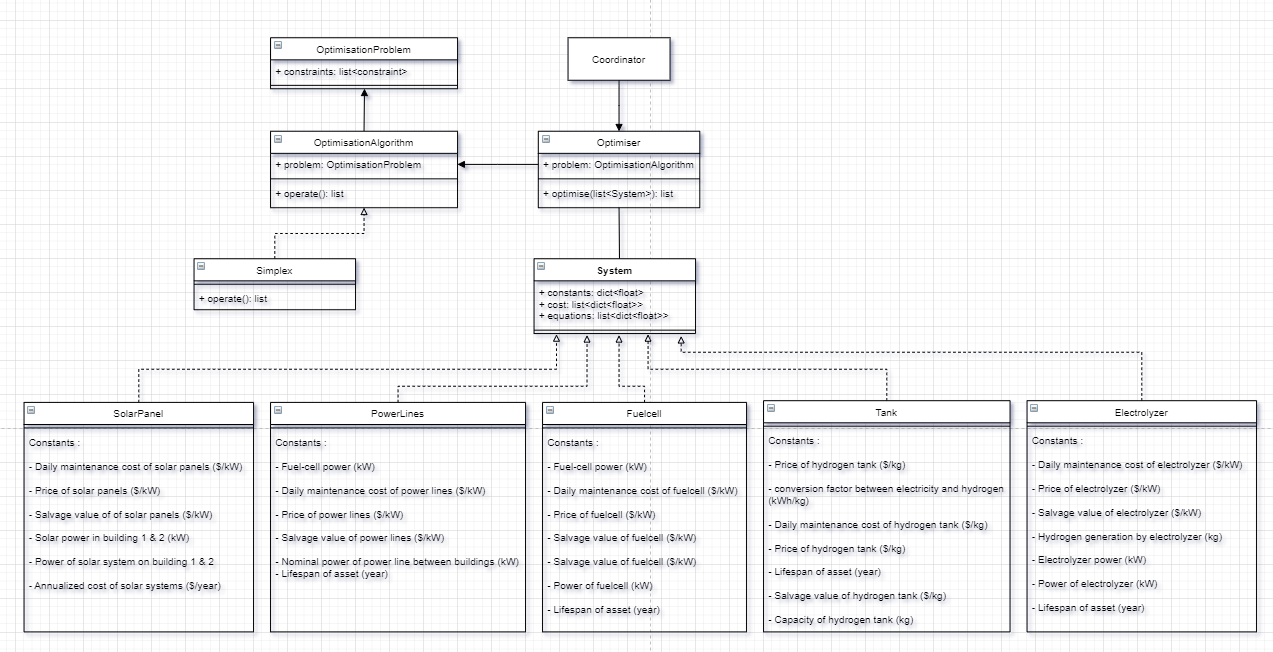

    

# Libraries

In [1]:
import numpy as np 
from mip import Model, MINIMIZE, CBC, OptimizationStatus, xsum
import pandas as pd
import matplotlib.pyplot as plt

# Loading data

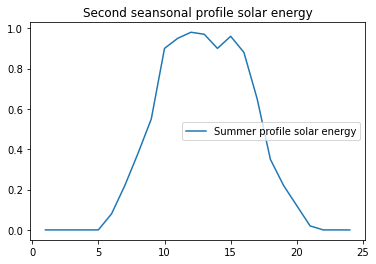

In [2]:
profile_solar = np.array([0,0,0,0,0,8,22,38,55,90,95,98,97,90,96,88,65,35,22,12,2,0,0,0]) # (article)
profile_solar = [0.01*val for val in profile_solar]

hours = np.arange(1,25,1)
plt.plot(hours,profile_solar,label='Summer profile solar energy')
plt.legend()
plt.title('Second seansonal profile solar energy')
plt.show()

def loading_builds(power_load, season, list_file_loads):
    if len(power_load)!=len(list_file_loads):
        print("Problème")
        return 0
    else:
        load_builds=[]
        for k in range(len(power_load)):
            loading_batiment = pd.read_csv(list_file_loads[k],delimiter=' ')
            load_builds.append([((power_load[k]*x)/100) for x in loading_batiment[season].tolist()])
        return load_builds

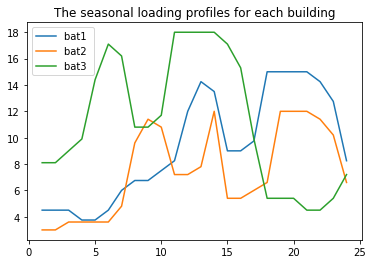

In [3]:
list_files=['loading_batiment1.txt','loading_batiment2.txt','loading_batiment3.txt'] # (article)
power_load=[15,12,18]
buildings=loading_builds(power_load,'Season2',list_files)

for i in range(3):
    plt.plot(hours,buildings[i],label=f"bat{i+1} ")
    plt.title("The seasonal loading profiles for each building")
    plt.legend()
plt.show()

In [4]:
# table 4 (article)
# solar system
Prsc = 1200 # $/kW
Svsc = 0.1
Mcsc = 0.5 # $/kW
# hydrogen storage tank
Prht = 300 # $/kg
Svht = 0.2
Mcht = 0.2 # $/kg
# fuelcell
Prfc = 100 # $/kW
Svfc = 0.2
Mcfc = 0.2 # $/kW
# water electrolyzer
Prwe = 300 # $/kW
Svwe = 0.2
Mcwe = 0.2 # $/kW
# power lines
Prln = 100 # $/kW
Svln = 0.3
Mcln = 0.1 # $/kW

# 4. Data of the problem (article)
dr = 0.1
lssc = 10 # years
lsht = 5 # years
lsfc = 5 # years
lswe = 5 # years
lsln = 15 # years
cfeh = 40 # kWh/kg
nhs = 0.6

## CLASSES

In [5]:
class System(object):
    def __init__(self, ls, dr, Mc, Sv, Pr):
        self.Mc = Mc
        self.Pr = Pr
        self.ls = ls
        self.dr = dr
        self.Sv = self.Pr*Sv
    def get_EAC(self):
        return self.Pr*(self.dr*((self.dr+1)**self.ls)/(((1+self.dr)**self.ls)-1)) - self.Sv*(self.dr/(((1+self.dr)**self.ls)-1)) + self.Mc*365

class HydrogenTank(System):
    def __init__(self, ls, dr, Mc, Sv, Pr, nhs):
        self.nhs = nhs
        super(HydrogenTank, self).__init__(ls, dr, Mc, Sv, Pr)
    def add_constraints(self, model):
        pass
    def add_var(self, model):
        pass
    
class SolarPanel(System):
    def __init__(self, ls, dr, Mc, Sv, Pr, profile):
        self.profile = profile
        super(SolarPanel, self).__init__(ls, dr, Mc, Sv, Pr)
    def add_constraints(self, model):
        pass
    def add_var(self, model):
        pass

class PowerLine(System):
    def __init__(self, ls, dr, Mc, Sv, Pr):
        super(PowerLine, self).__init__(ls, dr, Mc, Sv, Pr)
    def add_constraints(self, model):
        pass
    def add_var(self, model):
        pass
    
class FuelCell(System):
    def __init__(self, ls, dr, Mc, Sv, Pr):
        super(FuelCell, self).__init__(ls, dr, Mc, Sv, Pr)
    def add_constraints(self, model):
        pass
    def add_var(self, model):
        pass

class Electrolyzer(System):
    def __init__(self, ls, dr, Mc, Sv, Pr, cfeh):
        self.cfeh = cfeh
        super(Electrolyzer, self).__init__(ls, dr, Mc, Sv, Pr)
    def add_constraints(self, model):
        pass
    def add_var(self, model):
        pass

class Optimiser(object):
    def __init__(self):
        self.status = None
        self.model = None

    def optimise(self, systems, buildings):
        self.model = Model(sense=MINIMIZE)
        
        # Variables
        pns1 = self.model.add_var(name='pns1')
        pns2 = self.model.add_var(name='pns2')
        pl12 = self.model.add_var(name='pl12')
        pl23 = self.model.add_var(name='pl23')
        pl31 = self.model.add_var(name='pl31')
        pnfc = self.model.add_var(name='pnfc')
        pnwe = self.model.add_var(name='pnwe')
        pnht = self.model.add_var(name='pnht')
        ps1 = [self.model.add_var(name=f'ps1_{k}') for k in range(24)]
        ps2 = [self.model.add_var(name=f'ps2_{k}') for k in range(24)]
        p12 = [self.model.add_var(name=f'p12_{k}', lb=float('-inf')) for k in range(24)]
        p21 = [self.model.add_var(name=f'p21_{k}', lb=float('-inf')) for k in range(24)]
        p13 = [self.model.add_var(name=f'p13_{k}', lb=float('-inf')) for k in range(24)]
        p31 = [self.model.add_var(name=f'p31_{k}', lb=float('-inf')) for k in range(24)]
        p23 = [self.model.add_var(name=f'p23_{k}', lb=float('-inf')) for k in range(24)]
        p32 = [self.model.add_var(name=f'p32_{k}', lb=float('-inf')) for k in range(24)]
        pfc = [self.model.add_var(name=f'pfc_{k}') for k in range(24)]
        pwe = [self.model.add_var(name=f'pwe_{k}') for k in range(24)]
        Ch = [self.model.add_var(name=f'Ch_{k}') for k in range(24)]
        Gh = [self.model.add_var(name=f'Gh_{k}') for k in range(24)]
        Hs = [self.model.add_var(name=f'Hs_{k}') for k in range(24)]
        hBin = [self.model.add_var(name=f'hBin_{k}', var_type='BINARY') for k in range(24)]
        
        # Cost
        self.model.objective = pns1*systems['SolarPanel1'].get_EAC() \
            + pns2*systems['SolarPanel2'].get_EAC() \
            + pl12*systems['PowerLine1'].get_EAC() \
            + pl23*systems['PowerLine2'].get_EAC() \
            + pl31*systems['PowerLine3'].get_EAC() \
            + pnfc*systems['FuelCell'].get_EAC() \
            + pnwe*systems['Electrolyzer'].get_EAC() \
            + pnht*systems['HydrogenTank'].get_EAC() # $
        
        # Constraints
        for k in range(24): # power balance in building 1
            self.model += buildings[0][k] + p12[k] + p13[k] - ps1[k] == 0 # kW
        for k in range(24): # solar power
            self.model += ps1[k] <= profile_solar[k]*pns1 # kW
        for k in range(24): # power balance in building 2
            self.model += buildings[1][k] + p23[k] + p21[k] - ps2[k] == 0 # kW
        for k in range(24): # solar power
            self.model += ps2[k] <= profile_solar[k]*pns2 # kW
        for k in range(24): # power balance in building 3
            self.model += buildings[2][k] + p31[k] + p32[k] + pwe[k] - pfc[k] == 0 # kW
        for k in range(24): # electrolyzer power
            self.model += pwe[k] <= pnwe # kW
        for k in range(24): # fuel-cell power
            self.model += pfc[k] <= pnfc # kW
        
        # transferred power
        for k in range(24):
            self.model += p12[k] + p21[k] == 0 # kW
        for k in range(24):
            self.model += p23[k] + p32[k] == 0 # kW
        for k in range(24): 
            self.model += p31[k] + p13[k] == 0 # kW
        # nominal capacity of the power lines 
        for k in range(24):
            self.model += p12[k] <= pl12 # kW
        for k in range(24):
            self.model += -p12[k] <= pl12 # kW
        for k in range(24):
            self.model += p23[k] <= pl23 # kW
        for k in range(24):
            self.model += -p23[k] <= pl23 # kW
        for k in range(24):
            self.model += p13[k] <= pl31 # kW
        for k in range(24):
            self.model += -p13[k] <= pl31 # kW
        
        for k in range(24): # hydrogen consumption
            self.model += systems['Electrolyzer'].cfeh*Ch[k] == pfc[k] # kW
        for k in range(24): # hydrogen generation
            self.model += systems['Electrolyzer'].cfeh*Gh[k] == pwe[k] # kW
        self.model += Hs[0] == 8
        for k in range(1,24): # evolution of stored hydrogen
            self.model += Hs[k] == Hs[(k-1)%24] + Gh[k] - Ch[k] # kW
        self.model += xsum(systems['HydrogenTank'].nhs*Gh[k] for k in range(24)) == xsum(Ch[k] for k in range(24)) # kg # efficiency of hydrogen storage system
        for k in range(24): # the system cannot work on both the charring and discharging states
            self.model += Gh[k] <= 1e10*hBin[k] # kg
            self.model += Ch[k] <= 1e10*(1-hBin[k]) # kg
        for k in range(24): #  hydrogen container
            self.model += Hs[k] <= pnht # kg
        
        # Optimize
        self.status = self.model.optimize()
        
        # Affichage du status
        if self.status == OptimizationStatus.OPTIMAL:
            print('optimal solution cost {} found'.format(self.model.objective_value))
        elif self.status == OptimizationStatus.FEASIBLE:
            print('sol.cost {} found, best possible: {} '.format(self.model.objective_value, self.model.objective_bound))
        elif self.status == OptimizationStatus.NO_SOLUTION_FOUND:
            print('no feasible solution found, lower bound is: {} '.format(self.model.objective_bound))
        if self.status == OptimizationStatus.OPTIMAL or self.status == OptimizationStatus.FEASIBLE:
            print('solution:')
        tab_results = [v.x for v in self.model.vars]
            
        # Cost of powers lines
        z = tab_results[2]*systems['PowerLine1'].get_EAC() + tab_results[3]*systems['PowerLine2'].get_EAC() + tab_results[4]*systems['PowerLine3'].get_EAC()
        print('Cost of powers lines :  ' + str(z))

        # Cost of solar panels
        z1 = tab_results[0]*systems['SolarPanel1'].get_EAC() + tab_results[1]*systems['SolarPanel2'].get_EAC()
        print('Cost of solar panels :  ' + str(z1))

        # Cost of fuelcell
        z2 = tab_results[5]*systems['FuelCell'].get_EAC()
        print('Cost of fuelcell :      ' + str(z2))

        # Cost of electrolyzer
        z3 = tab_results[6]*systems['Electrolyzer'].get_EAC()
        print('Cost of electrolyzer :  ' + str(z3))

        # Cost of hydrogen tank
        z4 = tab_results[7]*systems['HydrogenTank'].get_EAC()
        print('Cost of hydrogen tank : ' + str(z4))
        
        # Evolution of power lines from one building to another
        index = np.arange(1,25)
        list_p13 = [-res for res in tab_results[-216:-192]]
        list_p23 = tab_results[-192:-168]
        list_p12 = tab_results[-264:-240]
        plt.plot(index, list_p13, label='1->3')
        plt.plot(index, list_p23, label='2->3')
        plt.plot(index, list_p12, label='1->2')
        plt.title("Evolution p_ij (power lines)")
        plt.ylabel("Power (kW)")
        plt.xlabel("time (h)")
        plt.legend()
        plt.show()
        
        # Evolution of Gh and Ch
        list_Gh = [-res for res in tab_results[272:296]]
        list_Ch = tab_results[248:272]
        plt.plot(index, list_Gh, label='Hydrogen generation')
        plt.plot(index, list_Ch, label='Hydrogen consumption')
        plt.title("Evolution of Gh and Ch")
        plt.ylabel("Hydrogen (kg)")
        plt.xlabel("time (h)")
        plt.legend()
        plt.show()
        
        # Evolution of Hs
        list_Hs = tab_results[-48:-24]
        plt.plot(index, list_Hs)
        plt.title("Evolution of Hs")
        plt.ylabel("Hydrogen (kg)")
        plt.xlabel("time (h)")
        plt.show()

optimal solution cost 50606.97928787753 found
solution:
Cost of powers lines :  3487.0853013864057
Cost of solar panels :  34312.67316223379
Cost of fuelcell :      2897.5295236769252
Cost of electrolyzer :  7599.929182953718
Cost of hydrogen tank : 2309.762117626699


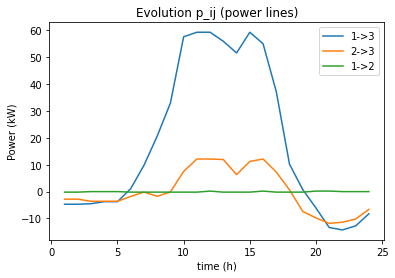

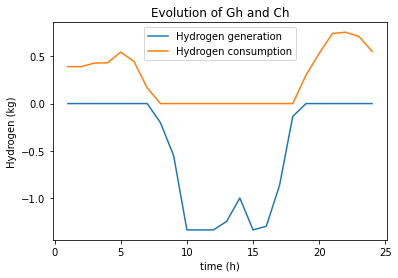

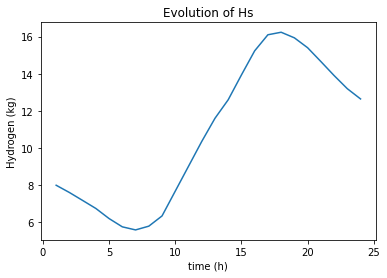

In [6]:
systems = {'SolarPanel1' : SolarPanel(lssc, dr, Mcsc, Svsc, Prsc, profile_solar),
           'SolarPanel2' : SolarPanel(lssc, dr, Mcsc, Svsc, Prsc, profile_solar),
           'PowerLine1' : PowerLine(lsln, dr, Mcln, Svln, Prln),
           'PowerLine2' : PowerLine(lsln, dr, Mcln, Svln, Prln),
           'PowerLine3' : PowerLine(lsln, dr, Mcln, Svln, Prln),
           'FuelCell' : FuelCell(lsfc, dr, Mcfc, Svfc, Prfc),
           'Electrolyzer' : Electrolyzer(lswe, dr, Mcwe, Svwe, Prwe, cfeh),
           'HydrogenTank' : HydrogenTank(lsht, dr, Mcht, Svht, Prht, nhs)}

optimiser = Optimiser()
optimiser.optimise(systems, buildings)
#optimiser.print_status()